In [2]:
import pandas as pd
import requests
import zipfile
import geopandas as gpd
from io import BytesIO
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
import os
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import atlite
import geopandas as gpd

### Line loading analysis

#### A) GIS Nuts-3 file: Germany

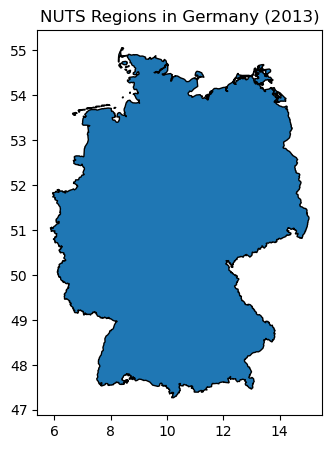

In [3]:
eu = gpd.read_file(r"C:\Users\par19744\Python_projects\ASSUME_project\ASSUME_Use_case\2035\assume\examples\inputs\example_06ab_analysis\NUTS_RG_03M_2013_4326_LEVL_0.shp.zip")
germany_nuts3 = eu[eu['CNTR_CODE'] == 'DE']
germany_nuts3.plot(figsize=(5, 5), edgecolor="black")
plt.title("NUTS Regions in Germany (2013)")
plt.show()

#### B) Buses

In [4]:
# Load buses data
buses_df = pd.read_csv("buses.csv")
buses_df=buses_df[['name','v_nom','x','y','carrier']]

# Convert buses DataFrame to a GeoDataFrame using longitude (x) and latitude (y)
geometry = [Point(xy) for xy in zip(buses_df['x'], buses_df['y'])]
buses_gdf = gpd.GeoDataFrame(buses_df, geometry=geometry, crs="EPSG:4326")

# Ensure the CRS matches between the NUTS3 shapefile and buses GeoDataFrame
buses_gdf = buses_gdf.to_crs(germany_nuts3.crs)

# Perform a spatial join to classify nodes into NUTS3 regions
buses_NUTS3 = gpd.sjoin(buses_gdf, germany_nuts3, how="left", predicate="within")

# Display the classified buses with their NUTS3 region info
buses_NUTS3 = buses_NUTS3[['name', 'x', 'y', 'NUTS_ID', 'geometry']]

# Explicitly convert classified_buses to a GeoDataFrame, ensuring geometry is set
buses_NUTS3 = gpd.GeoDataFrame(buses_NUTS3, geometry="geometry", crs=germany_nuts3.crs)
buses_NUTS3.head(2)

,name,x,y,NUTS_ID,geometry
0,DE1-220,13.677140,54.817281,NaN,POINT (13.67714 54.81728)
1,DE10-380,9.552734,53.563511,DE,POINT (9.55273 53.56351)


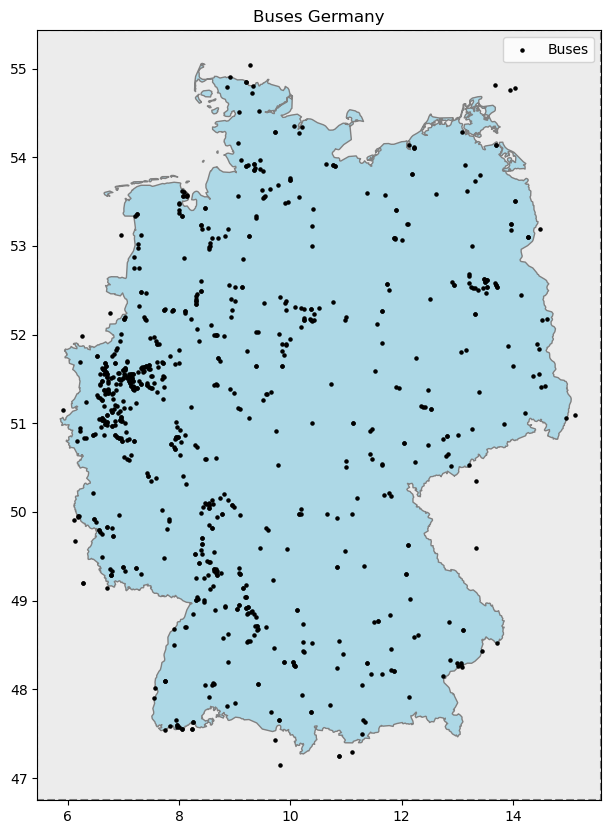

In [5]:
# Get the bounding box of the classified buses
bbox = buses_NUTS3.total_bounds  # [minx, miny, maxx, maxy]

# Calculate the center of the bounding box
center = [(bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2]

# Calculate the width and height of the bounding box with a margin
width = bbox[2] - bbox[0]
height = bbox[3] - bbox[1]
new_bbox = box(
    center[0] - width * 0.55, center[1] - height * 0.55,
    center[0] + width * 0.55, center[1] + height * 0.55
)

# Convert the bounding box to a GeoSeries
new_bbox = gpd.GeoSeries([new_bbox], crs=buses_NUTS3.crs)

# Plot the map for Germany with buses classified by NUTS3 regions
fig, ax = plt.subplots(figsize=(10, 10))
# Set background color to light gray
ax.set_facecolor("#ececec")

germany_nuts3.plot(ax=ax, edgecolor="gray", color="lightblue", alpha=1)
buses_NUTS3.plot(ax=ax, color="black", label="Buses", markersize=5)
new_bbox.boundary.plot(ax=ax, color="gray", linestyle="--")

plt.title("Buses Germany")
plt.legend()
plt.xlim(new_bbox.total_bounds[0], new_bbox.total_bounds[2])
plt.ylim(new_bbox.total_bounds[1], new_bbox.total_bounds[3])
plt.show()

#### C) Lines

In [6]:
# load powerplants_df csv file
lines_df = pd.read_csv('lines.csv')
lines_df=lines_df[['name','bus0','bus1','s_nom']]
lines_df.head(5)

,name,bus0,bus1,s_nom
0,merged_relation/1208415-380-c+1,way/23380800-380,way/24478889-380,1698.103
1,merged_way/24532884-1-380+6,way/23380800-380,way/24479984-380,1698.103
2,merged_relation/14592471-380-b+1,way/25306752-380,way/31131325-380,1698.103
3,way/167261399-1-380,way/25306752-380,DE199-380,1698.103
4,merged_way/36964218-1-380+2,DE198-380,DE199-380,1698.103


In [7]:
# Extract relevant columns from buses_df
buses_coords = buses_df[['name', 'x', 'y']].rename(columns={'name': 'bus'})

# Merge coordinates for bus0
lines_df = lines_df.merge(buses_coords, left_on='bus0', right_on='bus', how='left')
lines_df = lines_df.rename(columns={'x': 'x0', 'y': 'y0'}).drop(columns=['bus'])

# Merge coordinates for bus1
lines_df = lines_df.merge(buses_coords, left_on='bus1', right_on='bus', how='left')
lines_df = lines_df.rename(columns={'x': 'x1', 'y': 'y1'}).drop(columns=['bus'])

In [8]:
buses_NUTS3.head(2)

,name,x,y,NUTS_ID,geometry
0,DE1-220,13.677140,54.817281,NaN,POINT (13.67714 54.81728)
1,DE10-380,9.552734,53.563511,DE,POINT (9.55273 53.56351)


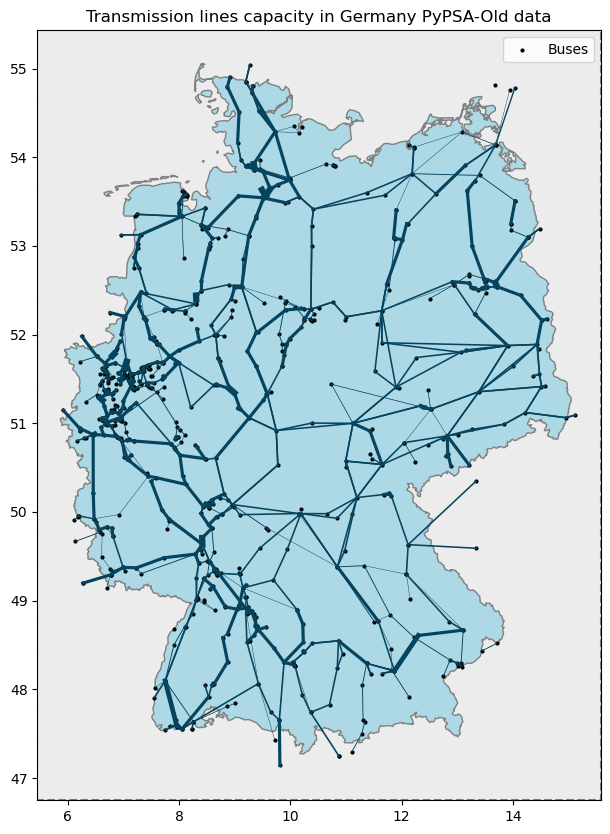

In [9]:
buses_visual=buses_NUTS3
lines_visual=lines_df

# Get the bounding box of the classified buses
bbox = buses_visual.total_bounds  # [minx, miny, maxx, maxy]

# Calculate the center of the bounding box
center = [(bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2]

# Calculate the width and height of the bounding box with a margin
width = bbox[2] - bbox[0]
height = bbox[3] - bbox[1]
new_bbox = box(
    center[0] - width * 0.55, center[1] - height * 0.55,
    center[0] + width * 0.55, center[1] + height * 0.55
)
# Convert the bounding box to a GeoSeries
new_bbox = gpd.GeoSeries([new_bbox], crs=buses_visual.crs)

# plot the lines on a map with the buses with Nuts3 regions here in new_lines_DE x0 and y0 is the starting point and x1 and y1 is the ending point
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor("#ececec")
germany_nuts3.plot(ax=ax, edgecolor="gray", color="lightblue", alpha=1)#"#ADD8E6")
buses_visual.plot(ax=ax, color="black", label="Buses", markersize=4)
new_bbox.boundary.plot(ax=ax, color="gray", linestyle="--")

for i in range(lines_visual.shape[0]):
    plt.plot([lines_visual['x0'][i], lines_visual['x1'][i]], [lines_visual['y0'][i], lines_visual['y1'][i]], color='#05445e', linewidth=lines_visual['s_nom'][i]/1500, alpha=1)


plt.title("Transmission lines capacity in Germany PyPSA-Old data")
plt.legend()
plt.xlim(new_bbox.total_bounds[0], new_bbox.total_bounds[2])
plt.ylim(new_bbox.total_bounds[1], new_bbox.total_bounds[3])
plt.show()


#### D) Line loading file

In [10]:
line_loading=pd.read_csv(r"C:\Users\par19744\Python_projects\ASSUME_project\ASSUME_Use_case\2035\assume\outputs\line_loading.csv")
line_loading.head(2)

,snapshot,merged_relation/1208415-380-c+1,merged_way/24532884-1-380+6,merged_relation/14592471-380-b+1,way/167261399-1-380,merged_way/36964218-1-380+2,merged_relation/14592735-380-c+1,merged_way/24833555-380+5,merged_way/24428845-1-380+1,merged_way/364135875-380+4,...,way/844126084-380,way/844126085-380,way/844126088-380,way/844126089-380,way/844126090-380,way/87280793-1-380,way/91655776-220,way/92877623-220,way/93258454-220,way/98382716-380
0,0,1.2695,1.2618,0.13949,0.14846,0.058581,0.56296,0.39135,0.61527,0.086421,...,0.004861,0.004834,0.004845,0.004822,0.015388,1.2471,3.0544,0.066725,0.048930,0.78672
1,1,1.7419,1.7348,0.28586,0.30900,0.090561,0.87408,0.55813,0.95849,0.013107,...,0.004702,0.004676,0.004687,0.004665,0.003374,1.7759,3.1416,0.066462,0.007441,1.23580


In [11]:
# create a timeseries starting from 2035-01-01 with hourly frequency
time_index = pd.date_range(start='2035-01-01', periods=line_loading.shape[0], freq='H')
line_loading.index = time_index
line_loading.index.name = 'timestamp'
line_loading = line_loading.drop(columns=['snapshot'])
line_loading.head(2)

,merged_relation/1208415-380-c+1,merged_way/24532884-1-380+6,merged_relation/14592471-380-b+1,way/167261399-1-380,merged_way/36964218-1-380+2,merged_relation/14592735-380-c+1,merged_way/24833555-380+5,merged_way/24428845-1-380+1,merged_way/364135875-380+4,relation/1102892-380-b,...,way/844126084-380,way/844126085-380,way/844126088-380,way/844126089-380,way/844126090-380,way/87280793-1-380,way/91655776-220,way/92877623-220,way/93258454-220,way/98382716-380
timestamp,,,,,,,,,,,,,,,,,,,,,
2035-01-01 00:00:00,1.2695,1.2618,0.13949,0.14846,0.058581,0.56296,0.39135,0.61527,0.086421,0.56167,...,0.004861,0.004834,0.004845,0.004822,0.015388,1.2471,3.0544,0.066725,0.048930,0.78672
2035-01-01 01:00:00,1.7419,1.7348,0.28586,0.30900,0.090561,0.87408,0.55813,0.95849,0.013107,1.05050,...,0.004702,0.004676,0.004687,0.004665,0.003374,1.7759,3.1416,0.066462,0.007441,1.23580


In [12]:
line_loading1 = (
    line_loading.gt(1)
    .sum()
    .reset_index()
    .rename(columns={0: "Overloaded", "index": "name"})
    .iloc[1:]
)
line_loading1.head(2)

,name,Overloaded
1,merged_way/24532884-1-380+6,5479
2,merged_relation/14592471-380-b+1,36


In [13]:
# Merge the DataFrames
lines_loading2 = lines_df.merge(line_loading1, on='name')
lines_loading2.head(2)

,name,bus0,bus1,s_nom,x0,y0,x1,y1,Overloaded
0,merged_way/24532884-1-380+6,way/23380800-380,way/24479984-380,1698.103,6.617347,51.475938,6.656881,51.379623,5479
1,merged_relation/14592471-380-b+1,way/25306752-380,way/31131325-380,1698.103,9.425109,48.064602,9.645341,47.744597,36


##### 1) Line loading: Overload frequency

C:\Users\par19744\AppData\Local\Temp\ipykernel_33228\4090301705.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("YlOrRd") #viridis #plasma #cividis #magma #bwr #coolwarm #RdYlBu #RdYlGn #YlGnBu #YlOrRd #Spectral #cubehelix #inferno


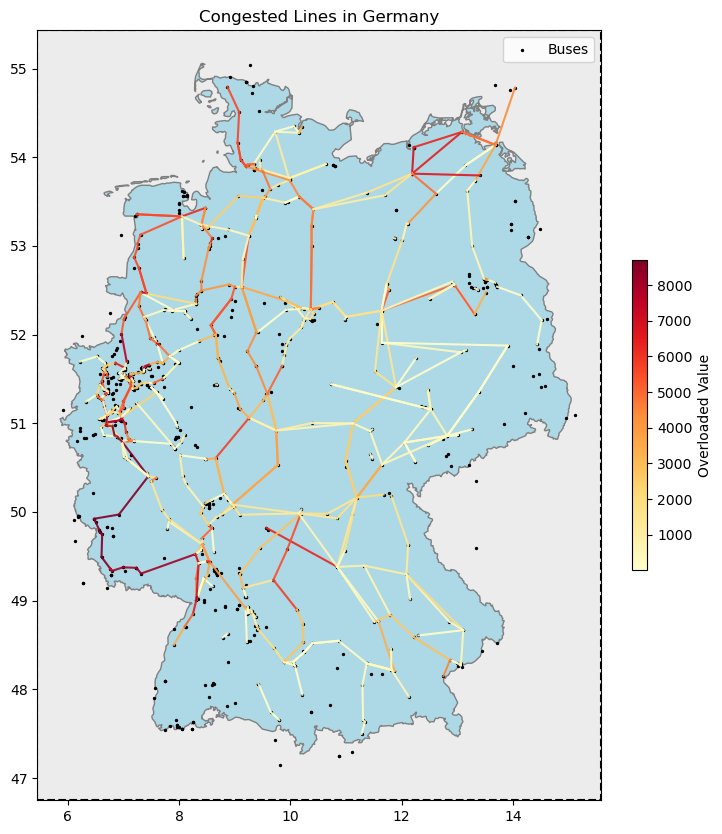

In [21]:
# Filter lines with Overloaded > 0
lines_visual = lines_loading2[lines_loading2["Overloaded"] > 0]

# Normalize based on filtered values
norm = mcolors.Normalize(
    vmin=lines_visual["Overloaded"].min(),
    vmax=lines_visual["Overloaded"].max()
)
cmap = cm.get_cmap("YlOrRd") #viridis #plasma #cividis #magma #bwr #coolwarm #RdYlBu #RdYlGn #YlGnBu #YlOrRd #Spectral #cubehelix #inferno

fig, ax = plt.subplots(figsize=(10, 10))

# Plot Germany outline (transparent fill, only borders)
germany_nuts3.plot(ax=ax, edgecolor="gray", color="lightblue", alpha=1)

# Plot buses
ax.set_facecolor("#ececec")
buses_NUTS3.plot(ax=ax, color="black", markersize=2, label="Buses")

# Plot bounding box
new_bbox.boundary.plot(ax=ax, color="black", linestyle="--")

# Plot overloaded lines
for _, row in lines_visual.iterrows():
    color = cmap(norm(row["Overloaded"]))
    ax.plot(
        [row["x0"], row["x1"]],
        [row["y0"], row["y1"]],
        color=color,
        linewidth=1.5,
        alpha=0.9
    )

# Colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
cbar.set_label("Overloaded Value")

# Titles and limits
plt.title("Congested Lines in Germany")
plt.legend()
plt.xlim(new_bbox.total_bounds[0], new_bbox.total_bounds[2])
plt.ylim(new_bbox.total_bounds[1], new_bbox.total_bounds[3])
plt.show()


In [15]:
line_loading.head(2)

,merged_relation/1208415-380-c+1,merged_way/24532884-1-380+6,merged_relation/14592471-380-b+1,way/167261399-1-380,merged_way/36964218-1-380+2,merged_relation/14592735-380-c+1,merged_way/24833555-380+5,merged_way/24428845-1-380+1,merged_way/364135875-380+4,relation/1102892-380-b,...,way/844126084-380,way/844126085-380,way/844126088-380,way/844126089-380,way/844126090-380,way/87280793-1-380,way/91655776-220,way/92877623-220,way/93258454-220,way/98382716-380
timestamp,,,,,,,,,,,,,,,,,,,,,
2035-01-01 00:00:00,1.2695,1.2618,0.13949,0.14846,0.058581,0.56296,0.39135,0.61527,0.086421,0.56167,...,0.004861,0.004834,0.004845,0.004822,0.015388,1.2471,3.0544,0.066725,0.048930,0.78672
2035-01-01 01:00:00,1.7419,1.7348,0.28586,0.30900,0.090561,0.87408,0.55813,0.95849,0.013107,1.05050,...,0.004702,0.004676,0.004687,0.004665,0.003374,1.7759,3.1416,0.066462,0.007441,1.23580


##### 2) Line loading: Intensity of any particular timestamp

Minimum overloaded line at this snapshot: 1.0094
Maximum overloaded line at this snapshot: 9.7011


C:\Users\par19744\AppData\Local\Temp\ipykernel_33228\4093622675.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("YlOrRd")  # good sequential map for positive overloads


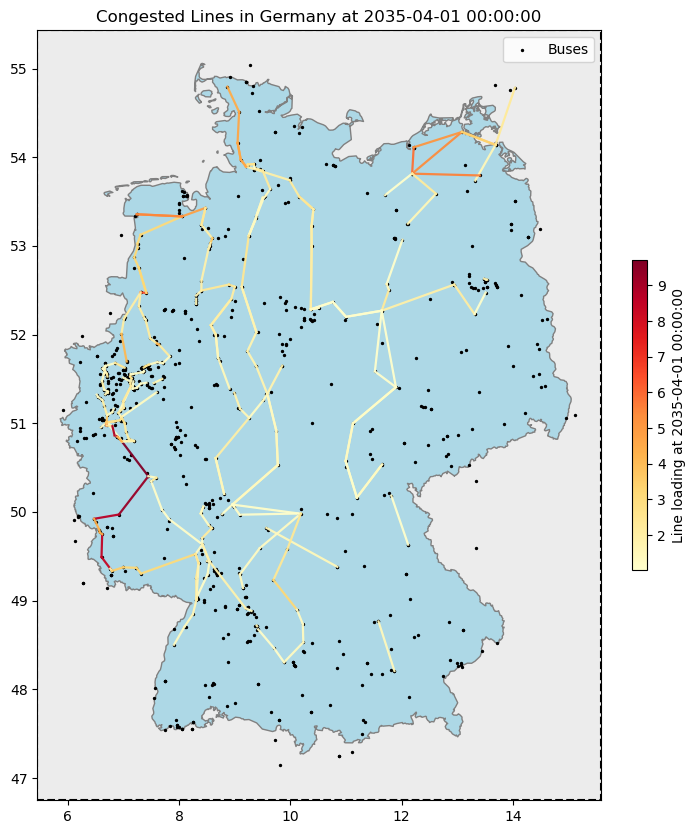

In [22]:
# 1) Pick the snapshot you want (edit this timestamp)
snap_ts = pd.to_datetime("2035-04-01 00:00")

# If the exact timestamp isn't present, use the nearest one
idx = line_loading.index.get_indexer([snap_ts], method="nearest")[0]
snap_ts_actual = line_loading.index[idx]        # actual timestamp used
snap_series = line_loading.iloc[idx]            # Series: index=line names, values=loading at that ts

# 2) Join snapshot load values onto line geometry
lines_snap = (
    lines_loading2
    .set_index("name")
    .join(snap_series.rename("Load"))
    .reset_index()
)

# 3) Keep only overloaded lines at this snapshot
lines_visual = lines_snap[lines_snap["Load"] > 1].copy()

# Guard: if nothing is overloaded, short-circuit with a friendly plot/text
if lines_visual.empty:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor("#ececec")
    germany_nuts3.plot(ax=ax, edgecolor="gray", color="lightblue", alpha=1)
    buses_NUTS3.plot(ax=ax, color="black", markersize=2, label="Buses")
    new_bbox.boundary.plot(ax=ax, color="black", linestyle="--")
    ax.set_title(f"No congested lines (>1 pu) at {snap_ts_actual}")
    ax.set_xlim(new_bbox.total_bounds[0], new_bbox.total_bounds[2])
    ax.set_ylim(new_bbox.total_bounds[1], new_bbox.total_bounds[3])
    plt.legend()
    plt.show()
else:
    # 4) Colormap + normalization (handle constant values safely)
    vmin = lines_visual["Load"].min()
    print("Minimum overloaded line at this snapshot:", vmin)
    vmax = lines_visual["Load"].max()
    print("Maximum overloaded line at this snapshot:", vmax)
    if vmin == vmax:
        vmax = vmin + 1e-9  # avoid zero-range norm

    cmap = cm.get_cmap("YlOrRd")  # good sequential map for positive overloads
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # 5) Plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Background / base layers
    ax.set_facecolor("#ececec")
    germany_nuts3.plot(ax=ax, edgecolor="gray", color="lightblue", alpha=1)
    buses_NUTS3.plot(ax=ax, color="black", markersize=2, label="Buses")
    new_bbox.boundary.plot(ax=ax, color="black", linestyle="--")

    # Overloaded lines at the snapshot
    for _, row in lines_visual.iterrows():
        ax.plot(
            [row["x0"], row["x1"]],
            [row["y0"], row["y1"]],
            color=cmap(norm(row["Load"])),
            linewidth=1.6,
            alpha=0.95,
        )

    # Colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
    cbar.set_label(f"Line loading at {snap_ts_actual}")

    # Titles and limits
    plt.title("Congested Lines in Germany at " + str(snap_ts_actual))
    plt.legend()
    plt.xlim(new_bbox.total_bounds[0], new_bbox.total_bounds[2])
    plt.ylim(new_bbox.total_bounds[1], new_bbox.total_bounds[3])
    plt.show()

##### 3) Line loading: Intensity **Average** over the year

C:\Users\par19744\AppData\Local\Temp\ipykernel_33228\2559604377.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("YlOrRd")  # good sequential map for positive overloads


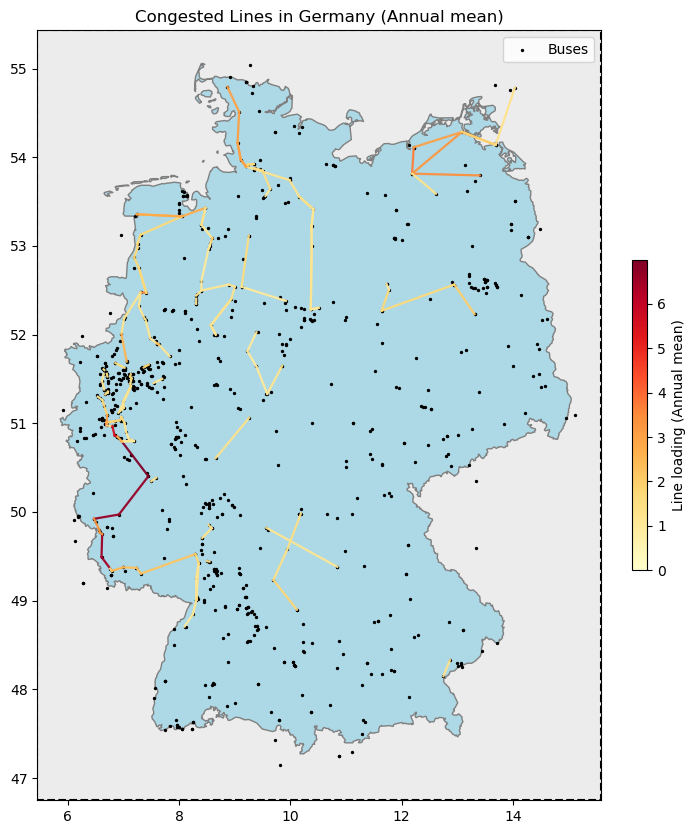

In [23]:
# 1) Average loading per line across all timesteps
avg_series = line_loading.mean(axis=0)  # Series: index=line names, values=avg load

# 2) Join averages onto line geometry
lines_avg = (
    lines_loading2
    .set_index("name")                # ensure this matches your line id column
    .join(avg_series.rename("Load"))  # add column "Load" with average values
    .reset_index()
)

# 3) Keep only lines with average overload > 1 pu
lines_visual = lines_avg[lines_avg["Load"] > 1].copy()

# 4) Handle "no congestion" case
if lines_visual.empty:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor("#ececec")
    germany_nuts3.plot(ax=ax, edgecolor="gray", color="lightblue", alpha=1)
    buses_NUTS3.plot(ax=ax, color="black", markersize=2, label="Buses")
    new_bbox.boundary.plot(ax=ax, color="black", linestyle="--")
    ax.set_title("No lines with average loading > 1 pu")
    ax.set_xlim(new_bbox.total_bounds[0], new_bbox.total_bounds[2])
    ax.set_ylim(new_bbox.total_bounds[1], new_bbox.total_bounds[3])
    plt.legend()
    plt.show()

else:
    # 5) Colormap + normalization
    # Option A: normalize to ALL averages (consistent scale across maps)
    vmin = lines_avg["Load"].min()
    vmax = lines_avg["Load"].max()

    # Option B (alternative): normalize only to overloaded ones
    # vmin = lines_visual["Load"].min()
    # vmax = lines_visual["Load"].max()

    if vmin == vmax:
        vmax = vmin + 1e-9  # avoid zero-range
    cmap = cm.get_cmap("YlOrRd")  # good sequential map for positive overloads
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # 6) Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor("#ececec")
    germany_nuts3.plot(ax=ax, edgecolor="gray", color="lightblue", alpha=1)
    buses_NUTS3.plot(ax=ax, color="black", markersize=2, label="Buses")
    new_bbox.boundary.plot(ax=ax, color="black", linestyle="--")

    # Draw overloaded lines with color by average load
    for _, row in lines_visual.iterrows():
        ax.plot(
            [row["x0"], row["x1"]],
            [row["y0"], row["y1"]],
            color=cmap(norm(row["Load"])),
            linewidth=1.6,
            alpha=0.95
        )

    # Colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
    cbar.set_label("Line loading (Annual mean)")

    # Titles and limits
    plt.title("Congested Lines in Germany (Annual mean)")
    plt.legend()
    plt.xlim(new_bbox.total_bounds[0], new_bbox.total_bounds[2])
    plt.ylim(new_bbox.total_bounds[1], new_bbox.total_bounds[3])
    plt.show()


##### 4) Line loading: Intensity **Maximum** in a year

C:\Users\par19744\AppData\Local\Temp\ipykernel_33228\343976588.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("YlOrRd")  # good sequential map for positive overloads


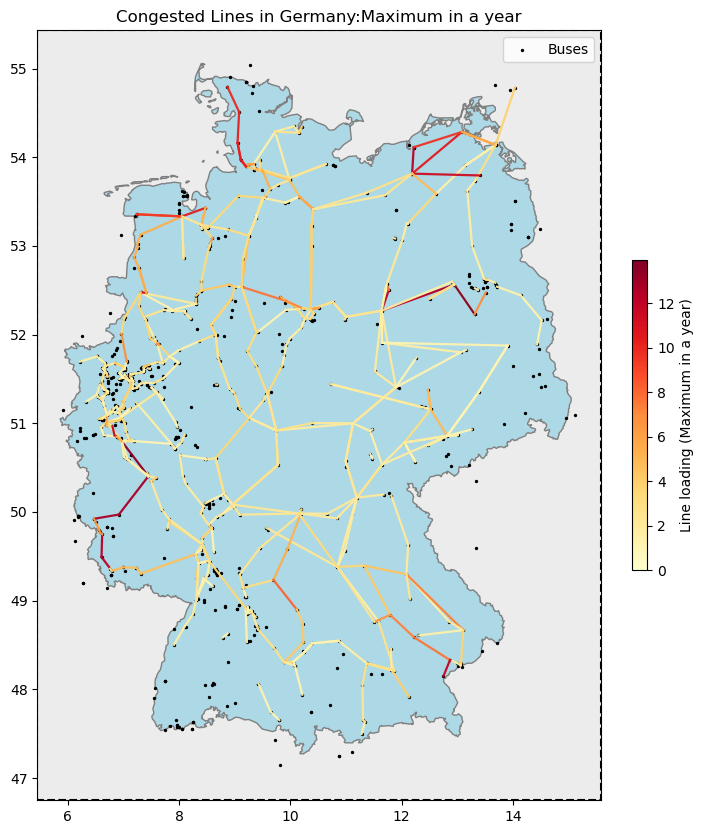

In [25]:
# 1) Average loading per line across all timesteps
avg_series = line_loading.max(axis=0)  # Series: index=line names, values=avg load

# 2) Join averages onto line geometry
lines_avg = (
    lines_loading2
    .set_index("name")                # ensure this matches your line id column
    .join(avg_series.rename("Load"))  # add column "Load" with average values
    .reset_index()
)

# 3) Keep only lines with average overload > 1 pu
lines_visual = lines_avg[lines_avg["Load"] > 1].copy()

# 4) Handle "no congestion" case
if lines_visual.empty:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor("#ececec")
    germany_nuts3.plot(ax=ax, edgecolor="gray", color="lightblue", alpha=1)
    buses_NUTS3.plot(ax=ax, color="black", markersize=2, label="Buses")
    new_bbox.boundary.plot(ax=ax, color="black", linestyle="--")
    ax.set_title("No lines with average loading > 1 ")
    ax.set_xlim(new_bbox.total_bounds[0], new_bbox.total_bounds[2])
    ax.set_ylim(new_bbox.total_bounds[1], new_bbox.total_bounds[3])
    plt.legend()
    plt.show()

else:
    # 5) Colormap + normalization
    # Option A: normalize to ALL averages (consistent scale across maps)
    vmin = lines_avg["Load"].min()
    vmax = lines_avg["Load"].max()

    # Option B (alternative): normalize only to overloaded ones
    # vmin = lines_visual["Load"].min()
    # vmax = lines_visual["Load"].max()

    if vmin == vmax:
        vmax = vmin + 1e-9  # avoid zero-range
    cmap = cm.get_cmap("YlOrRd")  # good sequential map for positive overloads
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # 6) Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor("#ececec")
    germany_nuts3.plot(ax=ax, edgecolor="gray", color="lightblue", alpha=1)
    buses_NUTS3.plot(ax=ax, color="black", markersize=2, label="Buses")
    new_bbox.boundary.plot(ax=ax, color="black", linestyle="--")

    # Draw overloaded lines with color by average load
    for _, row in lines_visual.iterrows():
        ax.plot(
            [row["x0"], row["x1"]],
            [row["y0"], row["y1"]],
            color=cmap(norm(row["Load"])),
            linewidth=1.6,
            alpha=0.95
        )

    # Colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
    cbar.set_label("Line loading (Maximum in a year)")

    # Titles and limits
    plt.title("Congested Lines in Germany:Maximum in a year")
    plt.legend()
    plt.xlim(new_bbox.total_bounds[0], new_bbox.total_bounds[2])
    plt.ylim(new_bbox.total_bounds[1], new_bbox.total_bounds[3])
    plt.show()
